In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [2]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Species_Richness>1. Species Richness</a><br>
    <!--<a href=#Simpsons_Diversity>2. Simpson's Diversity</a><br>
    <a href=#Shannons_Diversity>3. Shannon's Diversity</a><br> 
    <a href=#Evenness>4. Evenness</a><br><-->
    <a href=#Sorensons_Coefficient>2. Sorenson's Coefficient</a><br>
    <a href=#Dietary_Impacts>3. Dietary Impacts</a><br>
    &nbsp &nbsp <a href=#Dietary_Diversity>A. Dietary Diversity</a><br>
    &nbsp &nbsp <a href=#Nutrient_Diversity>B. Nutrient Diversity</a><br><br>

    <a href=#Top>Top</a><br>
    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
    
    <h4>PROJECT NOTEBOOKS</h4><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Project_Overview'>Project Overview</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Data_Coverage'>Data Coverage</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/General_Results'>General Results</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Global_Estimate'>Global Estimates</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Crop_Diversity'>Crop Diversity</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/Html/Sensitivity_Analyses'>Sensitivity Analyses</a><br>
    <a href='https://vinnyricciardi.github.io/farmsize_site/'>Site Index</a><br>
</div>
''')

<a name="Top"></a>
<center><h1>Crop Diversity by Farm Size</h1>


This section explores the relationship between farm size and crop diversity in our dataset. The hypothesis tested is that smaller farms have greater crop diversity, while larger farms specialize in a smaller number of crop species. Since our dataset is at the species level, a major caveat to these findings is that varietal diversity cannot be examined.

Three main take aways:
1. Diversity
    - As farms get larger, species richness declines.
    - Farms under 10 ha grow similar crops as each other, while farms over 50 ha grow crops similar to each other. Farms from 10 to 50 ha grow a different array of crops compared to other groups.<br><br>

2. Types of crops
    - Smaller farms produce more fruits, pulses, and tubers than other classes.
    - Medium farms produce more vegetables and nuts than other classes.
    - Large farms produce more oil crops and 'other' than other classes.<br><br>

3. Nutrients
    - Smaller farms grow a higher percentage of carbohydrates compared to other macro-nutrients.
    - Larger farms grow a higher percentage of proteins compared to other macro-nutrients.

In [3]:
import warnings
warnings.filterwarnings('ignore')
import subprocess
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib import lines
import copy
from collections import OrderedDict
from pivottablejs import pivot_ui  # may have to use: python setup.py install --user
import scipy.stats as st
import statsmodels.stats.api as sms
from scipy.stats import linregress
import matplotlib.patches as patches
from sklearn import linear_model
# import statsmodels.api as sm
import statsmodels.formula.api as smf
import math
import itertools
from collections import OrderedDict
import matplotlib as mpl
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import geopandas as gpd
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
from scikits import bootstrap

plt.style.use('seaborn-muted')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

%matplotlib inline

In [4]:
def read_data_init(path):
    
    data = pd.read_csv(path, low_memory=False)
    data['fs_class_max'] = np.where(data['fs_class_max'].isnull(), 10000, data['fs_class_max'])
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    data = data.replace(0.0, np.nan)  # there were many zero values
    
    return data

try:
    PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)
except:
    PATH = '/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
    data_orig = read_data_init(PATH)

# data_orig['Farm_Sizes'] = data_orig['Farm_Sizes'].astype(str)  # May have to set type depending on user's system

data_orig['production_kcal'] = data_orig['Production_fix'] * data_orig['kcal']
data_orig['Item_Code_ix'] = data_orig['Item_Code'].copy()
world = gpd.read_file('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/Shapefile/FSize.shp')
world = world.query("geometry == geometry")
world = world.to_crs({'init': 'epsg:3410'})
world['area'] = world['geometry'].area * 0.0001  # converts m**2 to ha
world = world.loc[:, ['shpID', 'area']]
data_orig = pd.merge(data_orig, world, on='shpID', how='left')

In [5]:
t = pd.pivot_table(data_orig, index=['Farm_Sizes'], values='NAME_0', aggfunc='count').reset_index()
t['perc'] = 100* t['NAME_0'] / t['NAME_0'].sum()
large_obs = round(t.iloc[-1, -1], 2)

<a name="Species_Richness"></a>
<left><h3>Species Richness</h3></left><br>

First, we calculate species richness: the number of species (regardless of frequencies) each farm size class produced. Species richness shows a general decline in richness as farms increase in size. Note, the 95% confidence intervals were derived from country level estimates. Only the largest farm size class shows large differences from the other groups. This large farm size group should be interpreted with caution, as it has few observations ({{large_obs}}% of total observations).

In [6]:
richness1 = pd.pivot_table(data_orig, 
                          index=['shpID', 'Farm_Sizes'],  # 'NAME_0
                          values='Item_Code',
                          aggfunc=lambda x: len(x.unique())).reset_index()

richness2 = pd.pivot_table(richness1, 
                           index=['shpID'],  # 'NAME_0
                           values='Item_Code',
                           aggfunc=np.nansum).reset_index()

richness = pd.merge(richness1, richness2, on='shpID', how='outer')
richness = pd.merge(richness, world, on='shpID', how='left')

richness['Item_Code_perc'] = richness['Item_Code_x'] / richness['Item_Code_y']  

fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
            '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
            '(500, 1000]', '(1000, 100000]']

dictionary = dict(zip(fs_order, range(0, len(fs_order))))  # used to circumvent categorical indexing
richness['ix'] = richness['Farm_Sizes'].map(dictionary)

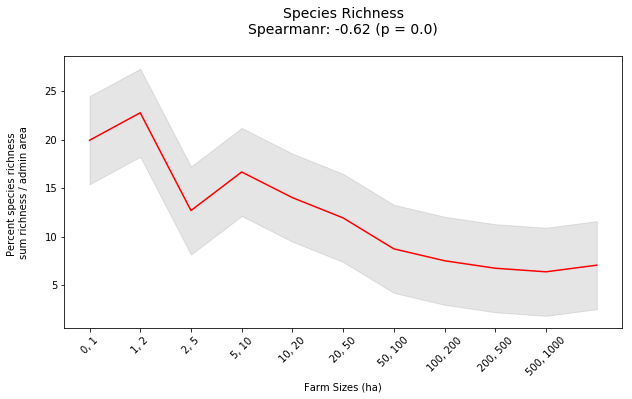

In [7]:
r, p = spearmanr(richness['ix'], richness['Item_Code_perc'])

fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)
y = richness['Item_Code_perc'] * 100
x = richness['ix']
pv = pd.pivot_table(richness, index='ix', values='Item_Code_perc', aggfunc=np.nanmean).reset_index()
y = pv['Item_Code_perc']*100
se = np.sqrt((y - y.mean())**2)
se = np.mean(se)
h = y + se
l = y - se

ax.fill_between(pv['ix'], h, l, color='grey', alpha=0.2)
ax.plot(pv['ix'], pv['Item_Code_perc']*100, '-r', alpha=1)

ax.set_xlabel('Farm Sizes (ha)')
ax.set_xticks(np.arange(0, 10))
ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)
ax.set_ylabel('Percent species richness \nsum richness / admin area\n')
ax.set_title('Species Richness\nSpearmanr: {} (p = {})\n'.format(round(r, 2), round(p, 2)), fontsize=14)

plt.show()

In [8]:
def area_richness_parallel(farmsizes=[0, 2], boots=2, grouped=False):
    
    farmsizes = range(farmsizes[0], farmsizes[-1])
    
    tmp = data_orig.copy()
    tmp['ix'] = tmp['Farm_Sizes'].map(dictionary)
    
    if grouped is True:
    
        tmp['Farm_Sizes'] = np.where(tmp['ix'] >= 7,
                                     '(100, 100000]',
                                     np.where(tmp['ix'] <= 3,
                                              '(0, 10]',
                                              '(10, 100]'))
        
        tmp = tmp.loc[(tmp['Farm_Sizes'] == '(100, 100000]') | 
                      (tmp['Farm_Sizes'] == '(0, 10]') | 
                      (tmp['Farm_Sizes'] == '(10, 100]')]
                       
        fs_order = ['(0, 10]',
                    '(10, 100]',
                    '(100, 100000]']

    else:
        
        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
            '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
            '(500, 1000]', '(1000, 100000]']
    
    variables = ['Farm_Sizes', 'Item_Code', 'shpID', 'area']
    tmp = tmp.loc[:, variables]
    tmp = tmp.loc[tmp['area'] > 0.]
    tmp = tmp[variables].drop_duplicates()

    for f in xrange(farmsizes[0], farmsizes[-1]):
        
        print fs_order[f]
        items = []
        
        tmp1 = tmp.loc[tmp['Farm_Sizes'] == fs_order[f]]

        grouped = tmp1.groupby(['Farm_Sizes', 'shpID', 'area'])
        out = grouped.aggregate(lambda x: tuple(x)).reset_index()

        for i in xrange(0, boots):

            out2 = out.iloc[np.random.permutation(len(out))]
            out2 = out2.reset_index(drop=True)

            for j in xrange(0, len(out2)-1):

                item = list(out2['Item_Code'][j])
                
                if j is 0:
                    item = item
                    
                else: 
                    item = list(item + items)
                
                nitem = list(out2['Item_Code'][j+1])
                items = list(item + nitem)
               
                out2.at[j, 'Item_Code'] = items
            
            out2['cumsum_area_{}'.format(i)] = out2['area'].cumsum()
            out2['cumsum_items_{}'.format(i)] = out2['Item_Code'].apply(lambda x: len(set(x)))
            
            out2 = out2.loc[:, ['Farm_Sizes', 
                                'shpID',
                                'cumsum_area_{}'.format(i), 
                                'cumsum_items_{}'.format(i)]]
            
            if i is 0:
                
                out3 = out2.copy()
                
            else:
                
                out3 = pd.merge(out3, out2, on=['Farm_Sizes', 'shpID'], how='outer')
                
        if f is farmsizes[0]:

            out4 = out3.copy()

        else:
            
            out4 = pd.concat([out4, out3], axis=0)
    
        
    return out4

In [9]:
def plot_cumulative_richness(data=None, fs_range=3, boots=1, ax=None, grouped=True):
    
    if ax is None:
    
        fig = plt.figure(figsize=[15, 5])
        ax = fig.add_subplot(131)
        ax2 = fig.add_subplot(132)
        ax3 = fig.add_subplot(133)
    
    else:
        ax=ax
        
    if grouped is True:
        
        fs_order = ['(0, 10]',
                    '(10, 100]',
                    '(100, 100000]']
        
        color_p = 'Set2'
        color_n = 3
        alpha = 0.1
        
    else:
        
        fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', '(10, 20]', 
            '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
            '(500, 1000]', '(1000, 100000]']
        
        color_p = 'BuPu_r'
        color_n = 11
        alpha = 0.1
        

    for i in xrange(len(fs_order)):

        x = data.loc[data['Farm_Sizes'] == fs_order[i]]

        for c in xrange(boots):

            y = x.sort_values('cumsum_area_{}'.format(c)).reset_index(drop=True)
            df_y = y.loc[:, ['cumsum_area_{}'.format(c), 'cumsum_items_{}'.format(c)]]
            df_y = df_y.loc[(df_y['cumsum_items_{}'.format(c)] > 100) & 
                            (df_y['cumsum_items_{}'.format(c)] < 140)]
            
            if c is 0:
                out = df_y.copy()
            else:
                out = pd.concat([out, df_y], axis=1)

            ax.plot(y['cumsum_area_{}'.format(c)][:-1], 
                    y['cumsum_items_{}'.format(c)][:-1], '-', 
                    color=sns.color_palette(color_p, color_n)[i],
                    linewidth=0.5,
                    alpha=alpha)

        out['areas'] = out.filter(regex='area').mean(axis=1)
        out['items'] = out.filter(regex='items').mean(axis=1)
        
        xlim_max_i = out['areas'].max()
        
        if i is 0:
            xlim_max = xlim_max_i
        else:
            if xlim_max < xlim_max_i:
                xlim_max = xlim_max
            else:
                xlim_max = xlim_max_i
         
        
        out = out.loc[(out['items'] > 100) & (out['items'] < 140)]
        out = out.loc[:, ['areas', 'items']]
        out['Farm_Sizes'] = fs_order[i]        
        
        if i is 0:
            out2 = out.copy()
    
        else:
            out2 = pd.concat([out2, out], axis=0)
    
    for i in xrange(len(fs_order)):

        x = out2.loc[out2['Farm_Sizes'] == fs_order[i]]

        ax.plot(x['areas'][:-1], 
                x['items'][:-1],
                color=sns.color_palette(color_p, color_n)[i], 
                alpha=1.,
                linewidth=1)

        
    ax.set_xlabel('Cumulative area (10e9 ha)')
    ax.set_ylabel('Cumulative species richness')
    
    if ax is None:
        
        fig.tight_layout()
        return plt.show()
 
    else:
        
        return ax

In [10]:
# Note: this is set to 1000 in our analysis. 
# Jupyter notebook kept crashing (dead kernel) with this script. 
# The external script we used to generate this plot can be found in our script pibrary under
# crop_diversity_bootstrap.py

boots = 1  
f_range = 12
t = area_richness_parallel(farmsizes=[0, f_range], boots=boots, grouped=False)  # uses all farm size classes
# g1 = area_richness_parallel(farmsizes=[0, 4], boots=boots, grouped=True)      # groups to sm, md, lg farm size classes

(0, 1]
(1, 2]
(2, 5]
(5, 10]
(10, 20]
(20, 50]
(50, 100]
(100, 200]
(200, 500]
(500, 1000]
(1000, 100000]


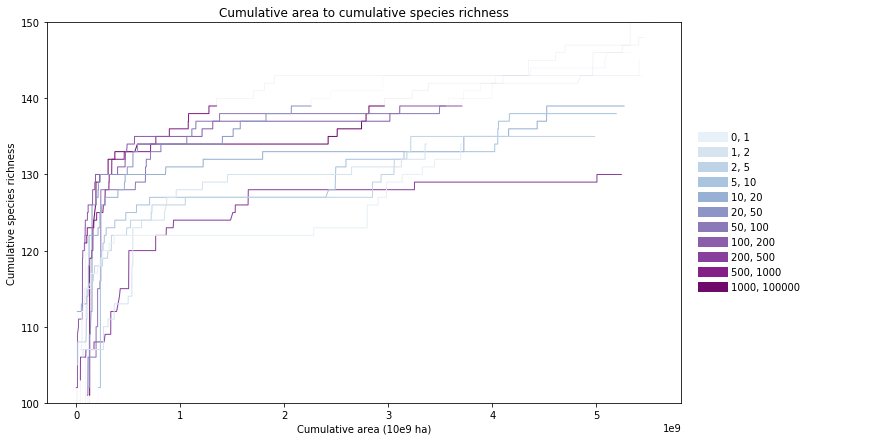

In [11]:
data = t

fs_order = ['(0, 1]',
            '(1, 2]',
            '(2, 5]',
            '(5, 10]',
            '(10, 20]',
            '(20, 50]',
            '(50, 100]',
            '(100, 200]',
            '(200, 500]',
            '(500, 1000]',
            '(1000, 100000]']

# fs_order = ['(0, 10]',  # Uncomment if use the grouped farm size classes setting above.
#             '(10, 100]',
#             '(100, 100000]']

# fig = plt.figure(figsize=[10, 15])
# ax = fig.add_subplot(211)

fig = plt.figure(figsize=(15, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[5, 1]) 
ax = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

plot_cumulative_richness(data=t, fs_range=len(fs_order), boots=boots, grouped=(len(fs_order) is 3), ax=ax)

mx = np.ceil(np.log(data['cumsum_area_0']).max())
my = np.ceil(np.log(data['cumsum_items_0']).max())

# ax2 = fig.add_subplot(212)  # Work around for legend to not have low alpha level.

for i in range(len(fs_order)):
    ax2.plot(mx, my,
            color=sns.color_palette('BuPu', len(fs_order))[i], 
            alpha=1,
            linewidth=0)
    
h = []

for i in xrange(len(fs_order)):

    h.append(sns.color_palette('BuPu', len(fs_order))[i])

legend = ax2.legend(h, labels=[x[1:-1] for x in fs_order], 
                    loc='center left',
                    bbox_to_anchor=(-0.5, 0.5))

for l in legend.legendHandles:            
    l.set_linewidth(10)

frame = legend.get_frame()
frame.set_facecolor('w')
frame.set_edgecolor('w')
ax2.axis('off')

# ax.set_xlim([7.5, mx])
ax.set_ylim([100, 150])
ax.set_title('Cumulative area to cumulative species richness')


plt.show();

In [12]:
# Below are scripts to calculate Shannon and Simspon Diversity Indices and Evenness.
# We choose not to use these for the scope of this paper, but may refine in a future effort.

In [13]:
# def diversity_indices(data, variable='production_kcal'):
    
#     if variable is 'production_kcal':
        
#         data[variable] = data[variable] / data['area']   # weight by shpID area
        
#         pivot = pd.pivot_table(data,
#                                index=['Farm_Sizes', 'Item_Code_ix'],  # 'NAME_0',
#                                values=variable,
#                                aggfunc=np.nansum).reset_index()
        
#         pivot2 = pd.pivot_table(data,
#                                index=['Farm_Sizes'],  # NAME_0
#                                values=variable,
#                                aggfunc=np.nansum).reset_index()
        
#         pivot = pd.merge(pivot, pivot2, 
#                          on=['Farm_Sizes'], 
#                          how='outer').reset_index()  # NAME_0
        
#     elif variable is 'Item_Code':
        
#         pivot = pd.pivot_table(data,
#                                index=['Farm_Sizes', 'shpID', 'area', 'Item_Code_ix'],  # NAME_0
#                                values=variable,
#                                aggfunc=np.count_nonzero).reset_index()
        
#         pivot['Item_Code'] = pivot['Item_Code'] / pivot['area']   # weight by shpID area
        
#         pivot2 = pd.pivot_table(data,
#                                index=['Farm_Sizes', 'shpID', 'area'], # NAME_0
#                                values=variable,
#                                aggfunc=np.count_nonzero).reset_index()

#         pivot2['Item_Code'] = pivot2['Item_Code'] / pivot2['area']  # weight by shpID area
#         pivot = pd.merge(pivot, pivot2, 
#                          on=['Farm_Sizes', 'shpID'], 
#                          how='outer').reset_index()  # NAME_0
    
#     pivot['p'] = pivot[variable + '_x'] / pivot[variable + '_y']
    
#     H = -1 * np.nansum(pivot['p'] * np.log(pivot['p']))
#     D = 1 - (np.nansum(pivot['p']**2))
   
#     return D, H
    
    
# def diversity_entire(data, variable='production_kcal', metric='simpsons'): 
    
#     farms = []
#     names = []
#     ds = []

#     for farm in data.loc[~data['Farm_Sizes'].isnull()]['Farm_Sizes'].unique():
        
#         tmp = data.loc[data['Farm_Sizes'] == farm]

#         for name in tmp['shpID'].unique():

#             tmp2 = tmp.loc[tmp['shpID'] == name]
            
#             d, h = diversity_indices(tmp2, variable=variable)

#             farms.append(farm)
#             names.append(name)
            
#             if metric is 'simpsons':
#                 ds.append(d)

#             elif metric is 'shannons':
#                 ds.append(h)
                
#     out = pd.concat([pd.DataFrame(farms, columns=['Farm_Sizes']),
#                      pd.DataFrame(names, columns=['shpID']),
#                      pd.DataFrame(ds, columns=['ds'])],
#                     axis=1)

#     return out
    
    
# def plot_diversity(data, title1="Species Diversity \n Simpson's Index"):

#     #fs_order = data_orig.sort_values('Farm_Sizes')['Farm_Sizes'].unique()
#     fig = plt.figure(figsize=[15, 5])
#     ax = fig.add_subplot(111)

#     sns.barplot(x='Farm_Sizes', 
#                 y='ds',
#                 data=data,
#                 color='grey', 
#                 order=fs, 
#                 ax=ax);
#     ax.set_xticklabels([str(x)[1:-1] for x in fs], rotation=45);
#     ax.set_xlabel('Farm Sizes (ha)');
#     ax.set_ylabel('Species Diversity');
#     ax.set_title(title1, fontsize=16);

#     fig.tight_layout()
    
#     return plt.show()

In [14]:
# d_prod = diversity_entire(data_orig, variable='production_kcal', metric='simpsons')
# plot_diversity(d_prod)

In [15]:
# Visually, there apears to be significant differences between the largest three farm size classes and the remaining classes except for the smallest farm size class.

In [16]:
# <a name="Shannons_Diversity"></a>
# <left><h3>Shannon's Diversity</h3></left><br>

# Since Simpson's Index tends to give more weight to dominant species, we will also calulate diversity with Shannon's Diversity Index. Shannon's Index is more affected by species richness than Simpson's Index and hence will indicate if a certain farm size class may have more overall crop diversity.

# \begin{equation*}
# H = \ -\sum_{i=1}^s \ p_i \ ln \ p_i
# \end{equation*}

# Where,<br>
# &nbsp;&nbsp;&nbsp;&nbsp; i = crop<br>
# &nbsp;&nbsp;&nbsp;&nbsp; s = number of species<br>
# &nbsp;&nbsp;&nbsp;&nbsp; p = proportion of individuals (n) divided by the total number of individuals (N)<br>
# &nbsp;&nbsp;&nbsp;&nbsp; s = number of species<br><br>

# We use the same modification as for the Simpson's index to weight the results by production.

# To do:
# - The code now accounts for admin boundary size
# - This diversity is now to be interpreted as a) directly comparing farm sizes in the same landscape and b) comparing the average diversity per farm size
# - Need to write into methodology

In [17]:
# h_prod = diversity_entire(data_orig, variable='production_kcal', metric='shannons')
# plot_diversity(h_prod, title1="Species Diversity \n Shannon's Index")

In [18]:
# To do: 
# - Rewrite interpretation from here down. there was a coding error found.

# The largest farm size class has more diversity than the other classes, while the second and third largest have the lowest crop diversity. These results are very different than the Simpson's Index, which may indicate that there are different crops being grown in the largest farm size class. Note, the largest farm size class should be interpretted with caution, since this class has farm fewer observations that may have led to a very low richness score; species richness affects both diversity indices.

In [19]:
# <a name="Evenness"></a>
# <left><h3>Evenness</h3></left><br>

# To further investigate the large differences between the Simpson and Shannon's indices we will first look at the distribution of crop prevelance in each farm size group. The assumption is that since the Simpson's Index minimizes crops that are not prevelent, the distribution (i.e., species evenness) of crops may explain the difference between the two diversity indices. While the richness metric counts how many crop species each farm size produces, evenness is the abundance (or distribution) of those species. Evenness can be calculated from the Shannon's Diversity index by dividing H by the natural log of species richness.

# To do:
# - The code now accounts for admin boundary size
# - This diversity is now to be interpreted as a) directly comparing farm sizes in the same landscape and b) comparing the average diversity per farm size
# - Need to write into methodology

In [20]:
# richness.columns = ['Farm_Sizes', 'shpID', 'Richness', 'area']
# merged = pd.merge(richness, h_prod, on=['Farm_Sizes', 'shpID'], how='outer')
# merged['ds'] = np.abs(merged['ds'] / np.log(merged['Richness']))

# plot_diversity(merged, title1="Species Evenness \n")

<a name="Sorensons_Coefficient"></a>
<left><h3>Sorenson's Coefficient</h3></left><br>

To test whether the crop composition is different between farm size classes, we will use the Sorenson's Coefficient (CC). Sorenson's Coefficient is a ratio of the number of overlapping species between two communities (farm size classes) and the total number of species across two communities.

\begin{equation*}
CC_{i,j} = \frac{2C_{i,j}}{S_i + S_j}
\end{equation*}

Where,<br>
C = the number of species the two classes have in common<br>
S = the total number of species found in the given farm size class<br>
i = farm size class 1<br>
j = farm size class 2<br><br>

Note: This calculation will be done for each i, j combination (i.e., all combinations of farm sizes will be compared)

In [21]:
tmp = data_orig.copy()
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].astype(str)

sorensons = pd.pivot_table(tmp, 
                           index=['shpID', 'Item_Code_ix'],
                           values='Item_Code',
                           columns='Farm_Sizes',
                           aggfunc=lambda x: float(len(x.unique())))

# sorensons = sorensons.iloc[:, : -1]

cols = sorensons.columns
combos = list(itertools.combinations(cols, 2))
Sn = pd.pivot_table(sorensons.reset_index(), index='shpID', aggfunc=np.nansum).iloc[:, :-1]

for i in xrange(len(combos)):
    sorensons['C_' + combos[i][0] + '_' + combos[i][1]] = np.where(((sorensons[combos[i][0]] > 0. ) &
                                                                     (sorensons[combos[i][1]] > 0. )), 1.0, np.nan)
    Sn['Sn_' +  combos[i][0] + '_' + combos[i][1]] = Sn[combos[i][0]] + Sn[combos[i][1]]

Sn = Sn.filter(regex='Sn_.*')
C = sorensons.filter(regex=('C_.*'))
C = pd.pivot_table(C.reset_index(), index='shpID', aggfunc=np.nansum).iloc[:, :-1]
CC = pd.DataFrame(2 * C.as_matrix() / Sn.as_matrix(), columns=C.columns, index=C.index).head()

In [22]:
t = CC.copy()
t = t.transpose().reset_index()
combos = t['Farm_Sizes'].str.split('_', expand=True)
combos.columns = ['C', 'Combo1', 'Combo2']

t = pd.concat([t, combos], axis=1)

for col in list(combos.columns[1:]):
    t[col] = t[col].str.replace('(', '')
    t[col] = t[col].str.replace(']', '')
    
t = t.sort_values(['Combo1', 'Combo2'])
t = t.set_index(['Combo1', 'Combo2'])
t = t.drop(['Farm_Sizes', 'C'], 1)
t = pd.DataFrame(t.mean(axis=1), columns=['CC']).reset_index()
tr = t.loc[:, ['Combo2', 'Combo1', 'CC']]
tr.columns = t.columns
t = pd.concat([t, tr], axis=0)
fs_order_u = [u'0, 1', u'1, 2', u'2, 5', u'5, 10', u'10, 20', 
              u'20, 50', u'50, 100', u'100, 200', u'200, 500', 
              u'500, 1000', u'1000, 100000']

# fs_order = [u'0, 2', u'2, 5', u'5, 10', u'10, 20',           # Uncomment if want to group < 2 ha
#             u'20, 50', u'50, 100', u'100, 200', u'200, 500', 
#             u'500, 1000', u'1000, 100000']

sorterIndex = dict(zip(fs_order_u,range(len(fs_order_u))))
t['Combo1_ix'] = t['Combo1'].map(sorterIndex)
t['Combo2_ix'] = t['Combo2'].map(sorterIndex)
t = t.sort_values(['Combo1_ix', 'Combo2_ix'])
t = t.iloc[:, 2:]
t = t.set_index(['Combo1_ix', 'Combo2_ix'])
t = pd.DataFrame(t.unstack())

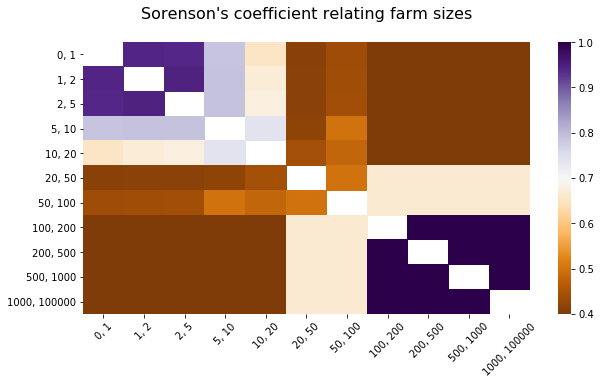

In [23]:
fig = plt.figure(figsize=[10,5])
ax = fig.add_subplot(111)
sns.heatmap(t.iloc[:,:], cmap='PuOr' , ax=ax);
ax.set_xlabel('');
ax.set_ylabel('');
fs_order_n = fs_order[:]
ax.set_xticklabels([x[1:-1] for x in fs_order_n], rotation=45);
ax.set_yticklabels([x[1:-1] for x in fs_order_n], rotation=0);
ax.set_title("Sorenson's coefficient relating farm sizes\n", fontsize=16);

The Sorenson's coefficient is plotted above. Higher (dark purple) values represent greater overlap in the crops the given farm size class pair produce, while darker brown values represent low overlap. For example, the 0 to 1 ha and 1 to 2 ha classes produce a large amount of the same crops, while the 0 to 1 ha and 500 to 1000 ha produce dissimilar crops. As we can see, the smaller farm sizes all grow similar crops as do the larger farm size cluster.

<a name="Dietary_Impacts"></a>
<left><h2>Dietary Impacts</h2></left><br>


<a name="Dietary_Diversity"></a>
<left><h3>Dietary Diversity</h3></left><br>

In [24]:
crop_types = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_Crop_types_lookup.csv')
crop_types['Item_Code'] = crop_types['Item Code']
crop_types['Item_Group'] = crop_types['Item Group']
crop_types = crop_types.loc[:, ['Item_Code', 'Item_Group']]
tmp = data_orig.loc[:, ['Farm_Sizes', 'NAME_0', 'shpID', 'area', 'Item_Code', 'production_kcal']]
tmp = pd.merge(tmp, crop_types, on=['Item_Code'], how='left')
tmp['production_kcal_area'] = tmp['production_kcal'] / tmp['area']

# There are 25 crops that are only in the crops primary category, mainly spices, sugar, coffee, chocolate.
# We recoded these as other.
tmp['Item_Group'] = np.where(tmp['Item_Code'].isin([711, 226, 459, 689, 693, 698, 661,
                                                    656, 720, 839, 677, 224, 671, 702,
                                                    687, 748, 754, 836, 723, 157, 156,
                                                    161, 667, 826, 692]), 'Other', tmp['Item_Group'])

# The commented out crop types were already accounted for in FAOSTAT, 
# so we did not include in order to avoid doubl-counting
crop_groups = ['Other',
               'Treenuts,Total',
               'Fruit Incl Melons', 
               'Vegetables Primary', 
               'Cereals,Total',
               'Pulses,Total',
               'Roots and Tubers,Total', 
               'Oilcrops Primary'] 
#                'Fibre Crops Primary', 
#                'Fruit excl Melons,Total', 
#                'Fruit Primary',
#                'Vegetables&Melons, Total', 
#                'Coarse Grain, Total', 
#                'Jute & Jute-like Fibres',
#                'Oilcakes Equivalent',
#                'Citrus Fruit,Total']

tmp = tmp.loc[tmp['Item_Group'].isin(crop_groups)]

tmp['ix'] = tmp['Farm_Sizes'].map(dictionary)
tmp = tmp.sort_values('ix')

pivot = pd.pivot_table(tmp, 
                       index=['ix'],
                       columns='Item_Group',
                       values='production_kcal', 
                       aggfunc=np.nansum)
pivot['total'] = pivot.sum(axis=1)

for col in pivot.columns[:-1]:
    pivot[col] = 100 * pivot[col] / pivot['total']
pivot = pivot.drop('total', axis=1)
pivot3 = pivot.copy()
pivot = pivot.reset_index()

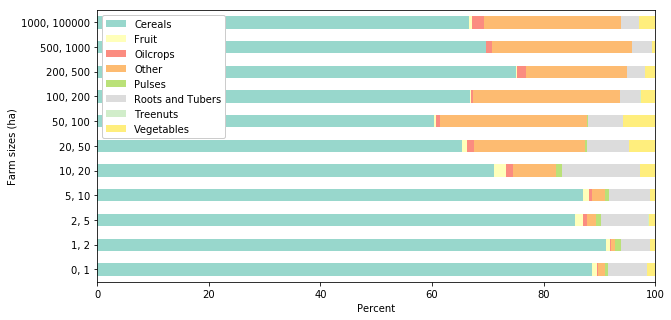

In [25]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

pivot3.plot(kind='barh',
           stacked=True,
           alpha=0.9,
           linewidth=0,
           grid=False,
           cmap=cm.get_cmap('Set3'),
           ax=ax)

labels = [x[1:-1] for x in fs_order]
ax.set_yticklabels(labels, rotation=0)
ax.set_ylabel('Farm sizes (ha)')
ax.set_xlabel('Percent')
handels, labels = ax.get_legend_handles_labels()
labels = ['Cereals',  
          'Fruit', 
          'Oilcrops', 
          'Other', 
          'Pulses', 
          'Roots and Tubers', 
          'Treenuts', 
          'Vegetables']
legend = ax.legend(handels, labels, title='', facecolor='w', loc='upper left')
legend.get_frame().set_alpha(1.)
ax.set_xlim([0, 100])

plt.show()


In [26]:
warnings.filterwarnings('ignore')

out = pd.DataFrame(columns=['ix', 'Item_Group', 'low', 'high'])

for i in tmp['Item_Group'].unique():

    tmp2 = tmp.loc[tmp['Item_Group'] == i]
    
    lows = []
    highs = []
    farms = []
    items = []

    for f in tmp['ix'].unique():
        try:
            tmp3 = tmp2.loc[tmp2['ix'] == f]
            low, high = bootstrap.ci(tmp3['production_kcal_area'].dropna(), 
                                     statfunction=np.nansum)
        
        except:
            low = np.nan
            high = np.nan
            
        farms.append(int(f))
        items.append(i)
        lows.append(low)
        highs.append(high)
    
    out1 = pd.concat([pd.DataFrame(farms, columns=['ix']),
                      pd.DataFrame(items, columns=['Item_Group']),
                      pd.DataFrame(lows, columns=['low']),
                      pd.DataFrame(highs, columns=['high'])],
                    axis=1)
    out = pd.concat([out, out1], axis=0)

out_ci = pd.pivot_table(out, 
                        index='Item_Group',
                        columns='ix',
                        values='high',
                        aggfunc=lambda x: np.abs(np.nanmax(x)))

out_ci.columns = out_ci.columns.astype(int)

pivot2 = pd.pivot_table(tmp, 
                        index='Item_Group',
                        columns='ix',
                        values='production_kcal', 
                        aggfunc=np.nansum)

pivot2['total'] = pivot2.sum(axis=1)
out_ci['total'] = out_ci.sum(axis=1)

for col in pivot2.columns[:-1]:
    pivot2[col] = pivot2[col] / pivot2['total']
    out_ci[col] = out_ci[col] / out_ci['total']

pivot2 = pivot2.drop('total', axis=1)
out_ci = out_ci.drop('total', axis=1)

pivot2 = pivot2.transpose().reset_index()
out_ci = out_ci.transpose().reset_index()

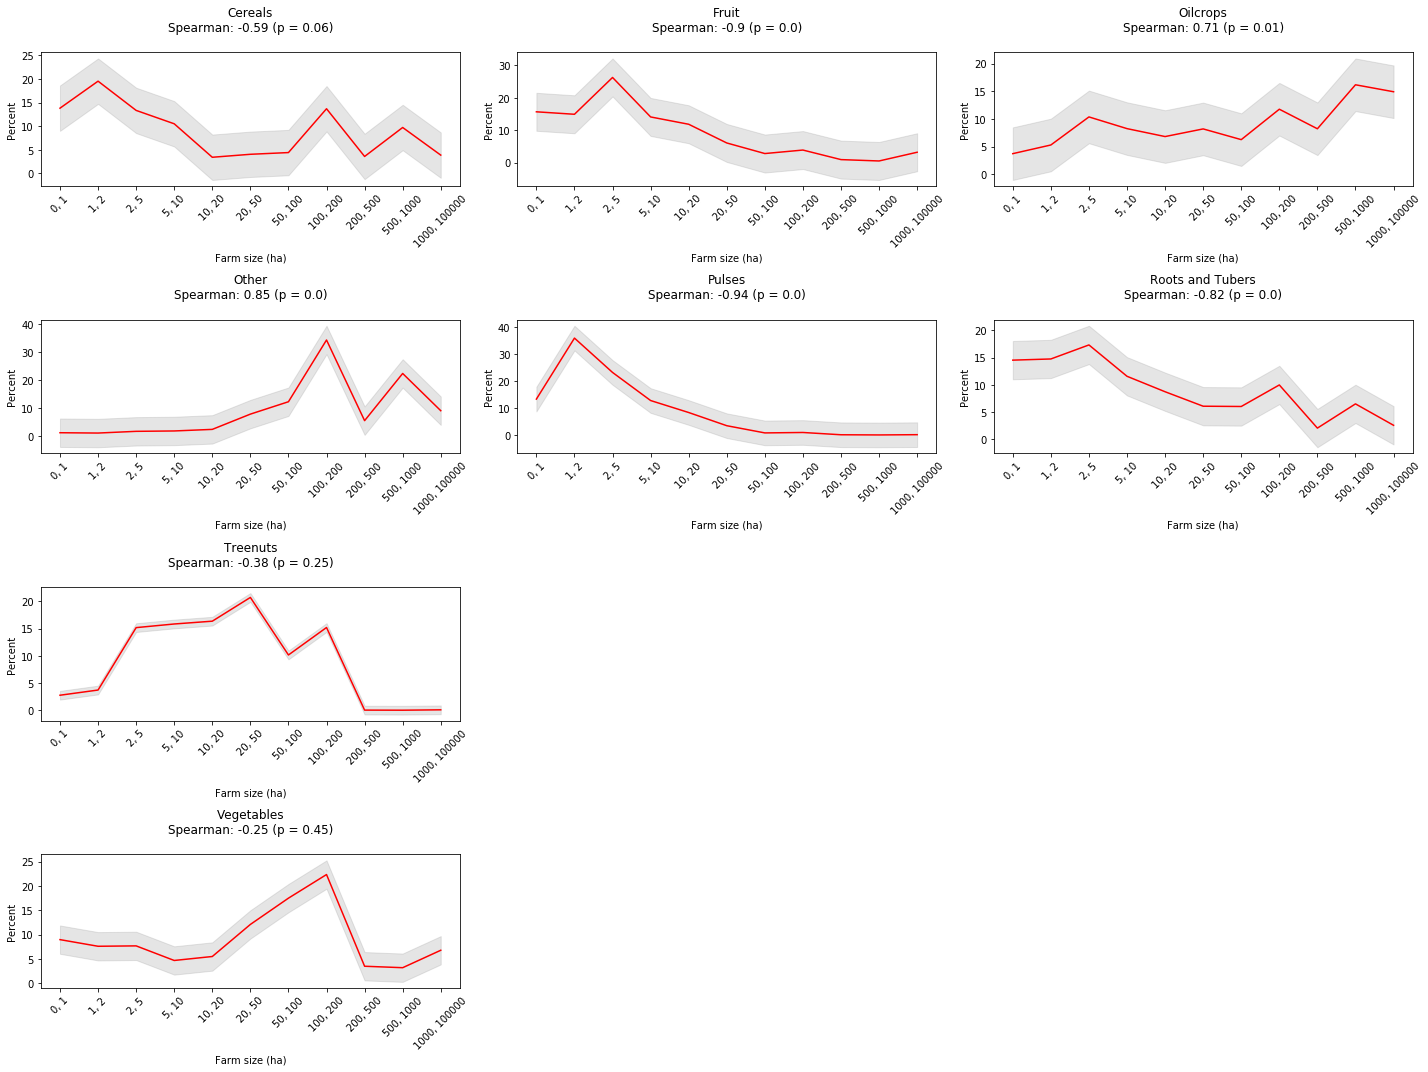

In [27]:
fig = plt.figure(figsize=[20, 15])

for c in xrange(1, len(pivot2.columns)):
    
    if c is len(pivot2.columns)-1:
        
        ax = fig.add_subplot(4, 3, 10)
    
    else:
        ax = fig.add_subplot(4, 3, c)
    
    v = pivot2.columns[c]
    y = pivot2[v] * 100
    x = pivot2['ix']
    e = out_ci[v] * 100

    se = np.sqrt((y - e)**2)
    se = np.mean(se)
    h = y + se
    l = y - se
    
    r, p = spearmanr(pivot2['ix'], pivot2[v])
    ax.plot(x, y, 'r-')
    ax.fill_between(x, h, l, color='grey', alpha=0.2)

    ax.set_title(labels[c-1] + '\nSpearman: {} (p = {})\n'.format(round(r, 2), round(p, 2)))
    ax.set_xticks(np.arange(0, len(fs_order)))
    
    ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)
    ax.set_xlabel('Farm size (ha)')
    ax.set_ylabel('Percent')

fig.tight_layout()
plt.show()

Above shows trends in the percentage of each crop type grown (summed production) by a farm size class. The data was bootstrapped to calculate confidence intervals. The smallest administrative unit weighted by its area was used for the bootstrap.
In general, there were clear patterns that larger farms produced more oilcrops and 'other'. Smaller farms produced more fruit, roots and tubers, and pulses. Mid-sized farms were responsible for treenuts and vegetables. Larger farms produce more oil crops.

<a name="Nutrient_Diversity"></a>
<left><h3>Nutrient Diversity</h3></left><br>

Finally, we will look at the carbohydrate, protein, and fat content of the crops each farm size class grows. Since the smaller farmsize classes showed greater similarity to one another in crops grown, and disimilarity with larger farms, we want to know if the food produced on smaller farms is providing a different set of nutrients. 

Due to data limitations, we were only able to calculate carbohydrates, protein, and fats for each crop grown. The conversion factors used were from the FAO food balance sheets.

Here we show the average carbohydrates, fat, and protein per crop per farm size group. Note, we first separated the data by the amount of food each farm size produced, then calculated the amount of kcal, fat, and protein in the available food as explained in the [General Results Notebook](https://vinnyricciardi.github.io/farmsize_site/Html/General_Results).

In [28]:
# FAO nutrition data
fao_nuts = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/FaoStat/FAOSTAT/FoodSupply_Crops_E_All_Data_(Norm).csv')

In [29]:
def add_fao_nutrients(data=data_orig, variable='None', var_name='None', fao_lookup=None, fao_kg=None):

    fao_kg = fao_kg.loc[fao_kg['Element'] == '{} supply quantity (g/capita/day)'.format(variable)]
    fao_kg = fao_kg.sort_values(['Country', 'Item Code', 'Year'])

    multi_index = pd.MultiIndex.from_product([fao_kg['Country'].unique(),
                                              fao_kg['Item Code'].unique(),
                                              fao_kg['Year'].unique()],
                                             names=['NAME_0', 'Item_Code', 'year'])

    fao_kg = fao_kg.set_index(['Country', 'Item Code', 'Year']).reindex(multi_index).reset_index()

    fao_kg = fao_kg.set_index(['NAME_0', 'Item_Code', 'year'])
    fao_kg = fao_kg.interpolate(method='linear',
                                axis=0,
                                limit_direction='both')

    fao_kg = fao_kg.reset_index()
    fao_kg = fao_kg.loc[:, ['NAME_0', 'Item_Code', 'year', 'Value', 'Item']]
    fao_kg.columns = ['NAME_0', 'Member_Key', 'year', var_name, 'Item']

    fao_lookup = fao_lookup.loc[fao_lookup['data'] == 'food']
    fao_lookup = fao_lookup.loc[:, ['Member_key', 'value']]
    fao_lookup.columns = ['Member_Key', 'Item_Code']
    fao_kg = pd.merge(fao_kg, fao_lookup, on='Member_Key', how='left')

    return fao_kg

In [30]:
fao_nuts = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/FaoStat/FAOSTAT/FoodSupply_Crops_E_All_Data_(Norm).csv')
fao_lookup = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAOStat_Lookup_Codes_fix2.csv')

A = add_fao_nutrients(data=data_orig, variable='Food', var_name='grams', fao_lookup=fao_lookup, fao_kg=fao_nuts)
B = add_fao_nutrients(data=data_orig, variable='Fat', var_name='fats', fao_lookup=fao_lookup, fao_kg=fao_nuts)
C = add_fao_nutrients(data=data_orig, variable='Protein', var_name='proteins', fao_lookup=fao_lookup, fao_kg=fao_nuts)

data = data_orig.copy()
data = pd.merge(data, A, on=['NAME_0', 'Item_Code', 'year'], how='left')
data = pd.merge(data, B, on=['NAME_0', 'Item_Code', 'year'], how='left')
data = pd.merge(data, C, on=['NAME_0', 'Item_Code', 'year'], how='left')

In [31]:
data = data.loc[(data['fats'] < data['grams']) & (data['proteins'] < data['grams'])]

data['carbs'] = (data['grams'] -  # this calculates carbohydrates
                 data['fats'] - 
                 data['proteins'])

data['total'] = data['grams'] + \
                data['fats'] + \
                data['proteins']

for i in ['grams', 'carbs', 'fats', 'proteins']:  # This calculates teh percentage of each macro-nutrient
    data['perc_' + i] = data[i] / data['total']


In [32]:
data['production_carb'] = data['Production_fix'] * data['perc_carbs']
data['production_fat'] = data['Production_fix'] * data['perc_fats']
data['production_protein'] = data['Production_fix'] * data['perc_proteins']

for i in ['grams', 'carbs', 'fats', 'proteins']:
    data['production_Food_{}'.format(i)] =  data['production_Food'] * data[i]
    
nutrients = data.loc[:, ['Farm_Sizes',
                         'shpID',
                         'area',
                         'production_Food_grams',
                         'production_Food_carbs', 
                         'production_Food_fats', 
                         'production_Food_proteins']]

nutrients['ix'] = nutrients['Farm_Sizes'].map(dictionary)

In [33]:
grouped = nutrients.groupby(['Farm_Sizes']).agg(np.nansum)
grouped = grouped.iloc[:, :].reset_index()

grouped['total'] = grouped.iloc[:, 4:7].sum(axis=1)

for i in ['carbs', 'fats', 'proteins']:
    grouped['production_Food_{}'.format(i)] =  grouped['production_Food_{}'.format(i)] / grouped['total']

for col in grouped.columns[3:]:
    grouped[col] = np.sqrt(grouped[col])

grouped['carbs'] = grouped['production_Food_carbs']
grouped['proteins'] = grouped['production_Food_proteins'] + grouped['carbs']
grouped['fats'] = grouped['production_Food_fats'] + grouped['proteins']

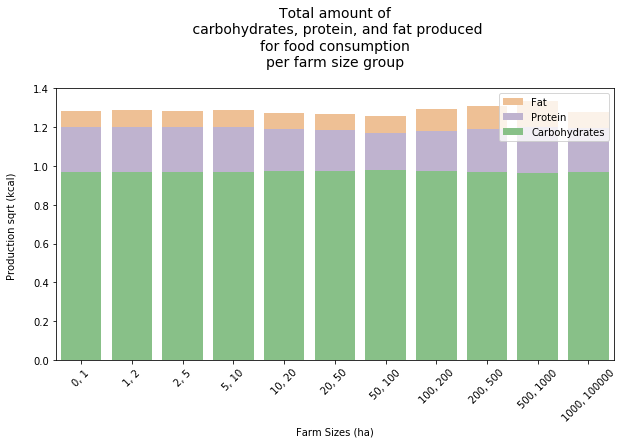

In [34]:
fig = plt.figure(figsize=[10, 5])
ax = fig.add_subplot(111)

plots = OrderedDict([('fats', ['Fat', '#fdc086', 'grey']),
                     ('proteins', ['Protein', '#beaed4', 'white']),
                     ('carbs', ['Carbohydrates', '#7fc97f', 'grey'])])

with mpl.rc_context({"lines.linewidth": 1}):
    colors = ["black", "grey", "white"]
    
    for key, value in plots.iteritems():

        g = sns.barplot(x='Farm_Sizes', 
                        y=key, 
                        data=grouped, 
                        label=value[0], 
                        color=value[1],
                        errcolor=value[2],
                        order=fs_order,
                        ax=ax)
    
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [x[1:-1] for x in labels]
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel('Farm Sizes (ha)')
ax.set_ylabel('Production sqrt (kcal) \n')

ax.set_title("Total amount of\n carbohydrates, protein, and fat produced\n"
             "for food consumption\n"
             "per farm size group\n",
            fontsize=14)

legend = ax.legend(frameon=True, fontsize=12)
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles[::-1], labels[::-1],
                   loc='center left',
                   frameon=1,
                   bbox_to_anchor=(1, 0.5))
frame = legend.get_frame()
frame.set_color('#ffffff')

ax.legend()
plt.show()

In the graph above we took the square-root of each macro-nutrient to place it on the same graph in relative terms since carbohydrates make up the majority of each farm size classes' macro-nutrient mix.

In [35]:
def boot_pivot(x, n_boots=1):
    
    l, h = bootstrap.ci(x, statfunction=np.nansum, n_samples=n_boots)
    s = x.sum()
    
    return l, h, s
    
    
def boot_nutrients(data, n_boots=1, how='across'):
    
    # data = data.loc[data['variable'] != 'production_Food_kcal']
    
    pivot = pd.pivot_table(data, 
                           index=['variable', 'ix'], 
                           values='value', 
                           aggfunc=[lambda x: boot_pivot(x, n_boots=n_boots)]).reset_index()
    
    pivot[['low', 'high', 'sums']] = pivot['<lambda>'].apply(pd.Series)

    out_ci = pd.pivot_table(pivot, 
                            index='variable',
                            columns='ix',
                            values='high',
                            aggfunc=lambda x: np.abs(np.nanmax(x)))

    out_ci.columns = out_ci.columns.astype(int)

    pivot2 = pd.pivot_table(data, 
                            index='variable',
                            columns='ix',
                            values='value', 
                            aggfunc=np.nansum)


    if how is 'across':

        pivot2['total'] = pivot2.sum(axis=1)
        out_ci['total'] = out_ci.sum(axis=1)

        for col in pivot2.columns[:-1]:
            pivot2[col] = pivot2[col] / pivot2['total']
            out_ci[col] = out_ci[col] / out_ci['total']

        pivot2 = pivot2.drop('total', axis=1)
        out_ci = out_ci.drop('total', axis=1)
        
        pivot2.columns = pivot2.columns.astype(int)
        out_ci.columns = out_ci.columns.astype(int)
        
        pivot2 = pivot2.transpose().reset_index()
        out_ci = out_ci.transpose().reset_index()
    
    if how is 'within':

        pivot2 = pivot2.transpose()
        out_ci = out_ci.transpose()
        
        pivot2['total'] = pivot2.sum(axis=1)
        out_ci['total'] = out_ci.sum(axis=1)

        for col in pivot2.columns[:-1]:
            pivot2[col] = pivot2[col] / pivot2['total']
            out_ci[col] = out_ci[col] / out_ci['total']

        pivot2 = pivot2.drop('total', axis=1)
        out_ci = out_ci.drop('total', axis=1)

        pivot2 = pivot2.reset_index()
        out_ci = out_ci.reset_index()

    pivot2.columns = list([x.split('_')[-1] for x in pivot2.columns])
    out_ci.columns = list([x.split('_')[-1] for x in out_ci.columns])
    
    return pivot2, out_ci

In [36]:
def plot_nutrients_boot(pivot2, out_ci):

    fig = plt.figure(figsize=[15, 5])

    for c in xrange(1, len(pivot2.columns)):
        
        r, p = spearmanr(pivot2['ix'], pivot2[pivot2.columns[c]])
        r = round(r, 2)
        p = round(p, 2)

        ax = fig.add_subplot(1, 3, c)

        # ax.plot(pivot2['ix'], pivot2[pivot2.columns[c]], 'r-')

        v = pivot2.columns[c]
        y = pivot2[v] * 100
        x = pivot2['ix'] 
        e = out_ci[v] * 100

        se = np.sqrt((y - e)**2)
        se = np.mean(se)
        h = y + se
        l = y - se
        
        ax.plot(x, y, 'r-')
        ax.fill_between(x, h, l, color='grey', alpha=0.2)

        ax.set_title(pivot2.columns[c].title() + '\nSpearman: {} (p = {})'.format(r, p))
        ax.set_xticks(np.arange(0, len(fs_order)))
        ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)
        ax.set_xlabel('Farm size (ha)')
        ax.set_ylabel('Percent')

    fig.tight_layout()
    
    return plt.show()

In [37]:
melted = pd.melt(nutrients, 
                 id_vars=['Farm_Sizes', 'ix', 'shpID', 'area'])
melted = melted.loc[melted['variable'] != 'production_Food_grams']

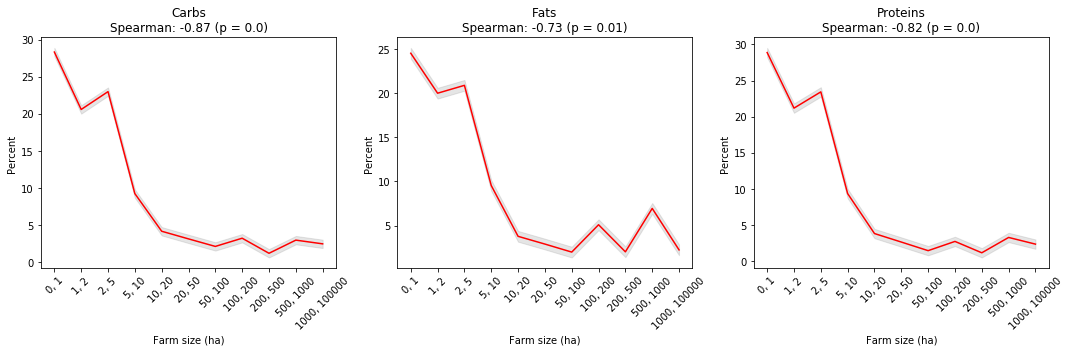

In [38]:
pivot2, out_ci = boot_nutrients(melted, n_boots=1, how='across')  # Run with boots=1 for quick plotting
plot_nutrients_boot(pivot2, out_ci)

Above shows the percentage of macro nutrients to all crop production across each farm size class. Due to the actual production being greater, smaller farms produce a higher percentages of all macro-nutrients than larger farms.

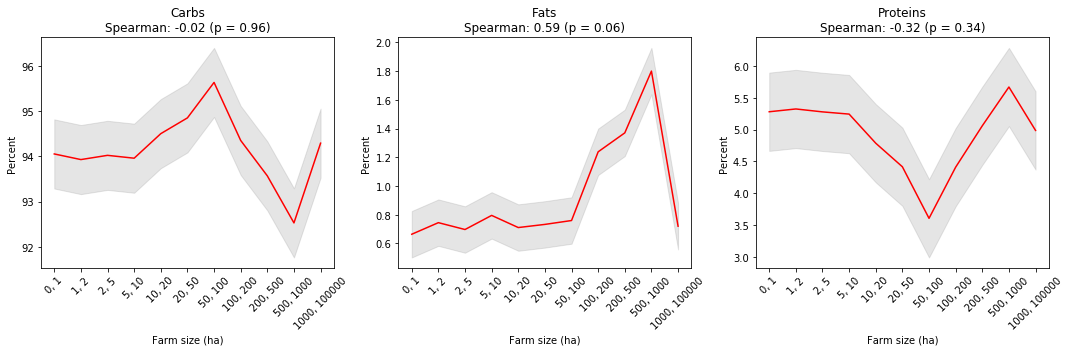

In [39]:
pivot2, out_ci = boot_nutrients(melted, n_boots=1, how='within')  # Run with boots=1 for quick plotting
plot_nutrients_boot(pivot2, out_ci)

Above shows within each farm size class, the percentage of macro nutrients to all crop production. Smaller farms produce a lower percentage of protein than larger farms, however, the small percentage differences show little practical significance in these differences.

###### Regional analysis on macro-nutrients and farm size

We checked for regional differences in the macro-nutrient analysis of within farm size class difference. Below shows our results. There is little regional difference, except in the fats category. However, the percentage differences are very small and no dot indicate practical significance.

Africa
Australia & New Zealand
Asia
Central America
Europe
Northern America
Oceania
South America


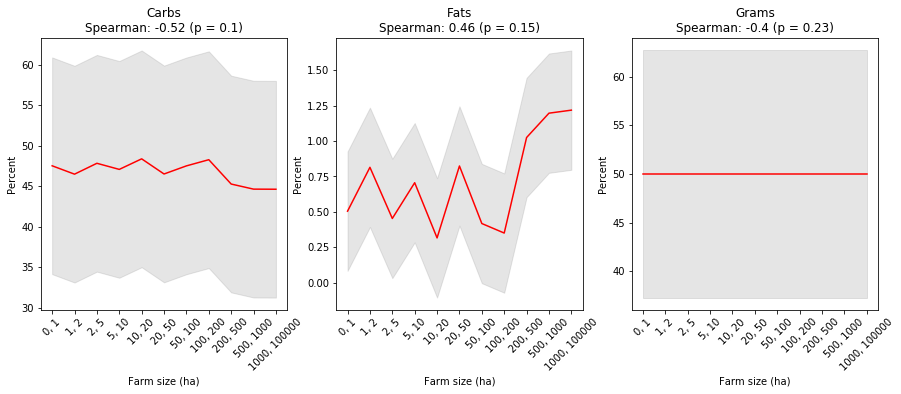

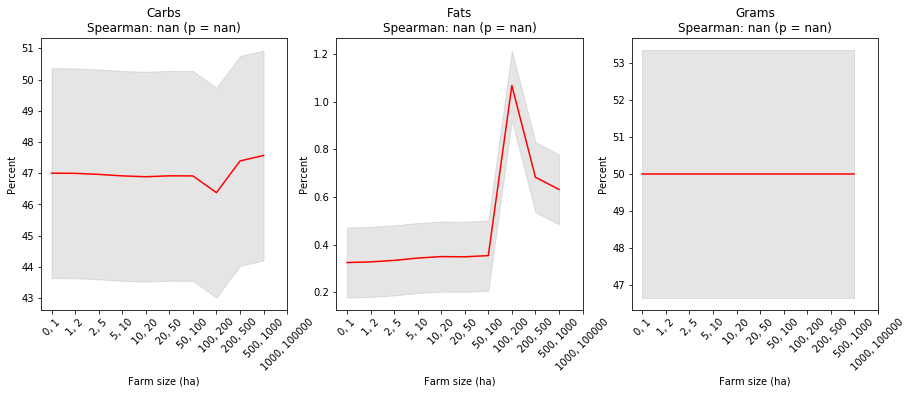

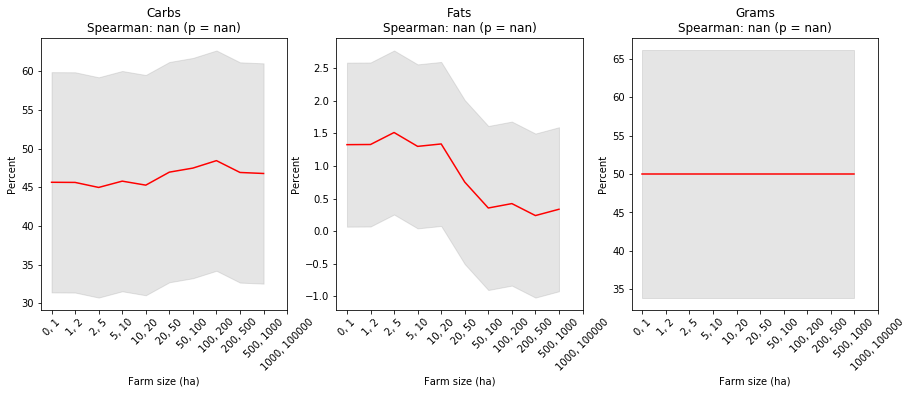

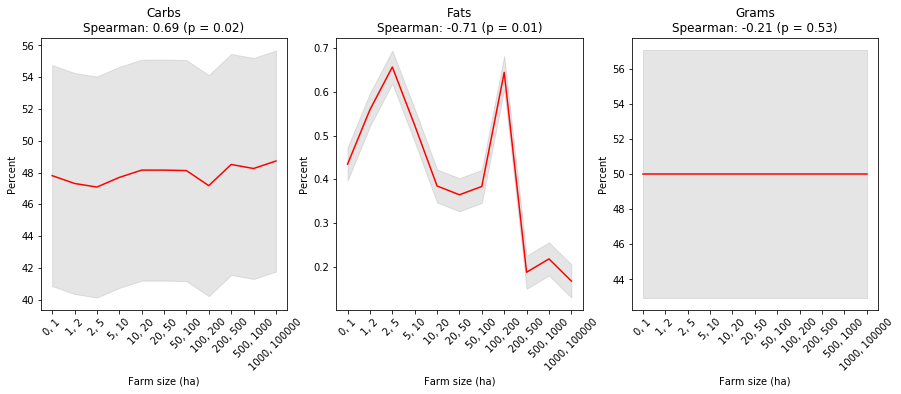

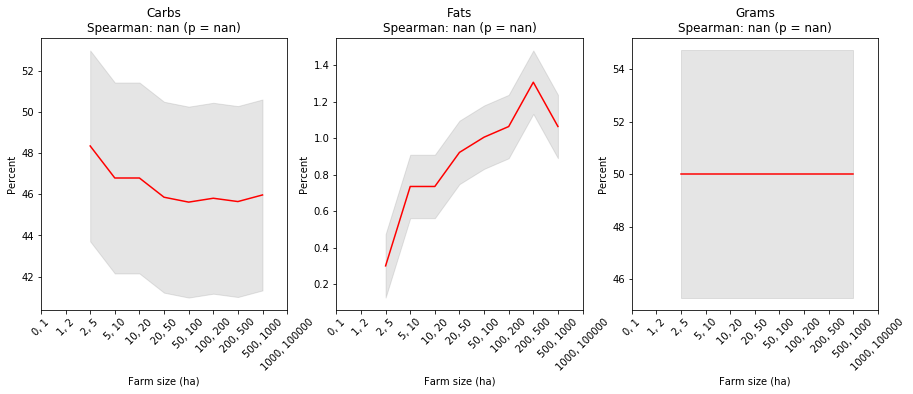

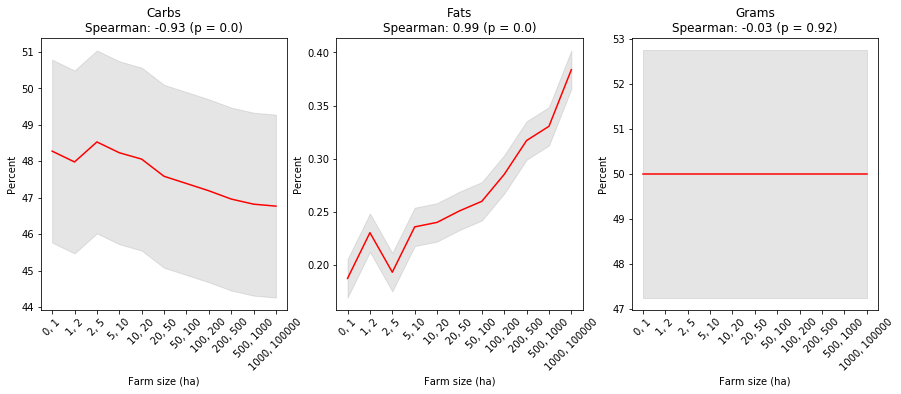

In [40]:
data2 = data.copy()

fao_regions = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
data2 = pd.merge(data2, fao_regions, left_on='NAME_0', right_on='Country', how='inner')

regions = ['Africa', 
           'Australia & New Zealand', 
           'Asia',
           'Central America', 
           'Europe', 
           'Northern America', 
           'Oceania', 
           'South America']

for region in xrange(len(regions)):
    
    print regions[region]
    
    try:
        data3 = data2.loc[data2['Country Group'] == regions[region]]

        nutrients = data3.loc[:, ['Farm_Sizes',
                                  'shpID',
                                  'area',
                                  'production_Food_grams',
                                  'production_Food_carbs', 
                                  'production_Food_fats', 
                                  'production_Food_proteins']]

        nutrients['ix'] = nutrients['Farm_Sizes'].map(dictionary)

        melted = pd.melt(nutrients, 
                     id_vars=['Farm_Sizes', 'ix', 'shpID', 'area'])

        pivot2, out_ci = boot_nutrients(melted, n_boots=1, how='within')
        plot_nutrients_boot(pivot2, out_ci)
    
    except:
        pass

In [41]:
# Below is the code for a crop group based analysis on macro-nutrient and farm size relationships
# This was not used in our publication

In [42]:
# lookup = pd.read_csv('/home/vinny_ricciardi/Documents/Data_Library_SSD/Survey/Global/Farm_Size/Data/FAO_FoodBalance/FAO_regional_lookup.csv')
# lookup = lookup.loc[:, ['Country Group', 'Country']]
# lookup.columns = ['region', 'NAME_0']

In [43]:
# tmp = data_orig.loc[:, ['Farm_Sizes', 'NAME_0', 'shpID', 'area', 'Item_Code', 'perc_Food',
#                         'production_Food_kcal', 'production_Food_fat', 'production_Food_protein']]

# tmp['production_Food_carb'] = (tmp['production_Food_kcal'] -  # this calculates carbohydrates
#                                tmp['production_Food_fat'] - 
#                                tmp['production_Food_protein'])

# tmp = tmp.loc[(tmp['production_Food_carb'] > 0.0) &
#               (tmp['production_Food_fat'] > 0.0) &
#               (tmp['production_Food_protein'] > 0.0)]


# tmp = pd.merge(tmp, crop_types, on=['Item_Code'], how='left')
# # tmp['production_kcal_area'] = tmp['production_kcal'] / tmp['area']
# # there are 25 crops that arte only in the crops primary category, mainly spices, sugar, coffee, chocolate.
# # We will recode as other.
# tmp['Item_Group'] = np.where(tmp['Item_Code'].isin([711, 226, 459, 689, 693, 698, 661,
#                                                     656, 720, 839, 677, 224, 671, 702,
#                                                     687, 748, 754, 836, 723, 157, 156,
#                                                     161, 667, 826, 692]), 'Other', tmp['Item_Group'])
# crop_groups = ['Other',
# #                'Fibre Crops Primary', 
#                'Treenuts,Total',
# #                'Fruit excl Melons,Total', 
#                'Fruit Incl Melons', 
# #                'Fruit Primary',
#                'Vegetables Primary', 
# #                'Vegetables&Melons, Total', 
#                'Cereals,Total',
# #                'Coarse Grain, Total', 
# #                'Jute & Jute-like Fibres', 
#                'Pulses,Total',
#                'Roots and Tubers,Total', 
#                'Oilcrops Primary'] 
# #                'Oilcakes Equivalent',
# #                'Citrus Fruit,Total']

# tmp = tmp.loc[tmp['Item_Group'].isin(crop_groups)]


# pivot1 = pd.pivot_table(tmp,
#                         index=['Farm_Sizes', 'Item_Group'],
#                         values=['production_Food_fat', 'production_Food_protein', 'production_Food_carb'],
#                         aggfunc=np.nansum).reset_index()

# pivot2 = pd.pivot_table(tmp,
#                         index=['Farm_Sizes'],
#                         values=['production_Food_fat', 'production_Food_protein', 'production_Food_carb'],
#                         aggfunc=np.nansum).reset_index()

# pivot = pd.merge(pivot1, pivot2, 
#                  on=['Farm_Sizes'],
#                  how='outer')

# pivot = pivot.set_index(['Farm_Sizes', 'Item_Group'])
# for raw, total in zip([col for col in pivot.columns if col.endswith('x')],
#                       [col for col in pivot.columns if col.endswith('y')]):
#     pivot[raw[:-1] + 'perc'] = pivot[raw] / pivot[total]
    
# pivot = pivot.iloc[:, -3:].reset_index()

In [44]:
# tmp = pivot.copy()
# # tmp = tmp.drop('shpID', 1)
# tmp['ix'] = tmp['Farm_Sizes'].map(dictionary)
# tmp = tmp.drop('Farm_Sizes', 1)

# variables = ['carb', 'protein', 'fat']
# fig = plt.figure(figsize=[20, 5])

# for v in xrange(0, len(variables)):
    
#     tmp2 = tmp.loc[:, ['ix', 'Item_Group', 'production_Food_{}_perc'.format(variables[v])]]
#     tmp3 = pd.pivot_table(tmp2, index=['ix'], columns='Item_Group', aggfunc=np.nanmean)

#     ax = fig.add_subplot(1,4,v+1)
    
#     tmp3.plot(kind='bar', 
#               cmap=cm.get_cmap('Set3', 11),
#               stacked=True, 
#               ax=ax)
    
#     ax.legend_.remove()
#     ax.set_title(variables[v].title() + 's')
#     ax.set_xticklabels([x[1:-1] for x in fs_order], rotation=45)
# #     ax.set_axis_bgcolor("#d6d7e5")
#     ax.set_xlabel('Farm size (ha)')
#     ax.set_ylabel('Percent')

# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# labels = ['Cereals',  
#           'Fruit', 
#           'Oilcrops', 
#           'Other', 
#           'Pulses', 
#           'Roots and Tubers', 
#           'Treenuts', 
#           'Vegetables']

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), labels=labels)

# fig.tight_layout()
# plt.show()